# # Creazione dataframe

In [13]:
import pandas as pd

df = pd.read_csv("dataset.csv")

In [ ]:
df['data'] = pd.to_datetime(df['anno'].astype(str) + '-' +
                            df['mese'].astype(str) + '-' +
                            df['giorno'].astype(str),
                            format='%Y-%m-%d')
# Riempi i NaN di 'uova_prodotte' con la mediana del mese corrispondente
df['uova_prodotte'] = (
    df.groupby(df['data'].dt.to_period('M'))['uova_prodotte']
      .transform(lambda x: x.fillna(x.median()))
)
# Calcola il numero medio di uova per gallina
df['uova_per_gallina'] = df['uova_prodotte'] / df['n_galline']

df = df.sort_values('data')

# Raggruppa per ogni 7 giorni (frequenza settimanale)
df_settimanale = (
    df.groupby(['capannone', 'razza', pd.Grouper(key='data', freq='7D')])
      .agg({'uova_per_gallina': 'mean'})
      .reset_index()
)
df_settimanale.rename(columns={'uova_per_gallina': 'media_uova_per_gallina_settimanale'}, inplace=True)

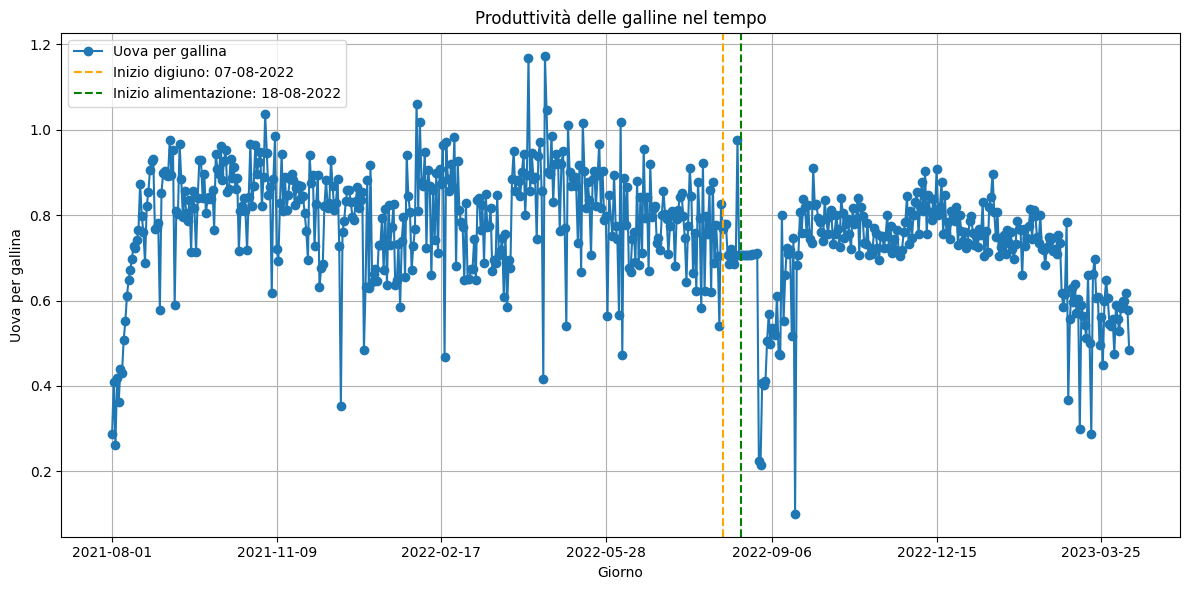

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
plt.plot(df['data'], df['uova_per_gallina'], marker='o', linestyle='-', label='Uova per gallina')

# Mostra solo un tick ogni 100 punti per chiarezza
plt.xticks(df['data'][::100], rotation=0)

# Aggiungi linee verticali per eventi speciali con colori diversi
eventi = {
    'Inizio digiuno: 07-08-2022': ('2022-08-07', 'orange'),
    'Inizio alimentazione: 18-08-2022': ('2022-08-18', 'green')
}

for label, (giorno, colore) in eventi.items():
    giorno_dt = pd.to_datetime(giorno)
    plt.axvline(giorno_dt, color=colore, linestyle='--', label=label)

plt.title('Produttività delle galline nel tempo')
plt.xlabel('Giorno')
plt.ylabel('Uova per gallina')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()  # evita che le etichette si sovrappongano
plt.show()


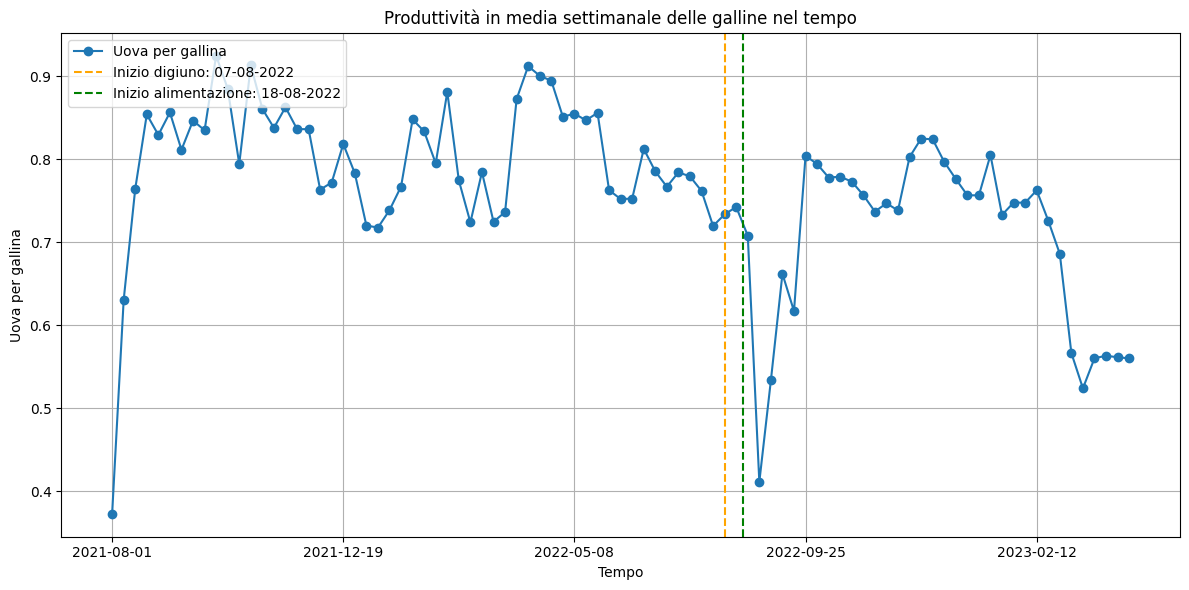

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
plt.plot(df_settimanale['data'], df_settimanale['media_uova_per_gallina_settimanale'], marker='o', linestyle='-', label='Uova per gallina')

# Mostra solo un tick ogni 20 punti per chiarezza
plt.xticks(df_settimanale['data'][::20], rotation=0)

# Aggiungi linee verticali per eventi speciali con colori diversi
eventi = {
    'Inizio digiuno: 07-08-2022': ('2022-08-07', 'orange'),
    'Inizio alimentazione: 18-08-2022': ('2022-08-18', 'green')
}

for label, (giorno, colore) in eventi.items():
    giorno_dt = pd.to_datetime(giorno)
    plt.axvline(giorno_dt, color=colore, linestyle='--', label=label)

plt.title('Produttività in media settimanale delle galline nel tempo')
plt.xlabel('Tempo')
plt.ylabel('Uova per gallina')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()  # evita che le etichette si sovrappongano
plt.show()

# Correlazione tempo e produttività

In [17]:
# Spearman Rank Correlation (ρ di Spearman)
# Serve per verificare se c’è una correlazione monotona tra il tempo e la produttività.

from scipy.stats import spearmanr
import numpy as np

# df_settimanale['media_uova_per_gallina_settimanale']

# Crea un array di settimane (1, 2, 3, ...)
weeks = np.arange(len(df_settimanale))

# Calcola la correlazione di Spearman
corr, pval = spearmanr(weeks, df_settimanale['media_uova_per_gallina_settimanale'])
print(f"Spearman rho = {corr:.3f}, p = {pval:.6f}")

# Spearman rho = -0.489, p = 0.000001
# significa che c’è una correlazione negativa moderata tra il tempo e la produttività, moderata se 
# si considera tutto lo storico. 
# Il p-value minore di 0.05 indica che questa correlazione è statisticamente significativa.

Spearman rho = -0.489, p = 0.000001


In [26]:
# Crea un array di settimane (1, 2, 3, ...) troncato alle ultime 44 settimane
df_settimanale_last_20 = df_settimanale.tail(20)
last_20_weeks = np.arange(len(df_settimanale_last_20))

# Calcola la correlazione di Spearman
corr, pval = spearmanr(last_20_weeks, df_settimanale_last_20['media_uova_per_gallina_settimanale'])
print(f"Spearman rho = {corr:.3f}, p = {pval:.9f}")

Spearman rho = -0.920, p = 0.000000009


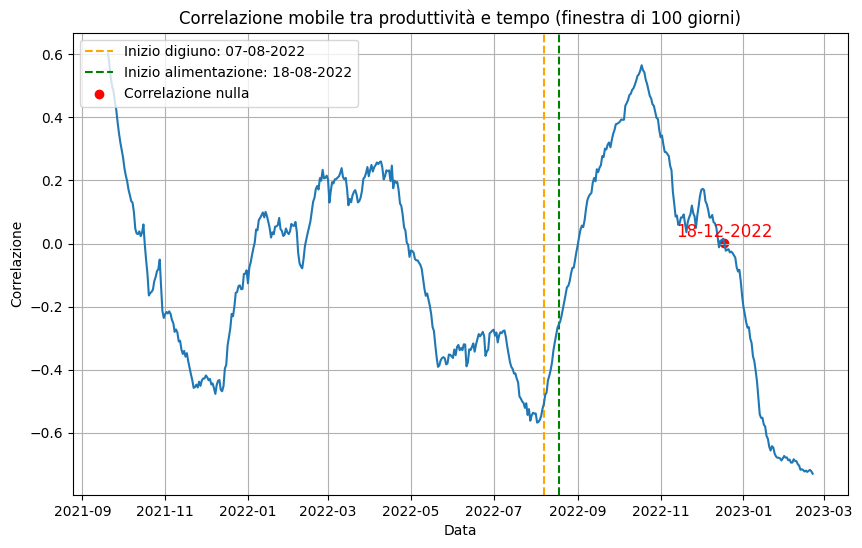

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# Crea un indice numerico dei giorni
df['giorno_indice'] = (df['data'] - df['data'].min()).dt.days

# Calcola la correlazione mobile usando rolling centrato
df['corr_mobile'] = (
    df['uova_per_gallina']
    .rolling(window=100, center=True)
    .corr(df['giorno_indice'])
)

zero_corr = df[df['corr_mobile'].abs() < 1e-2]
ultimo_zero = zero_corr.iloc[-1]
# Plot
plt.figure(figsize=(10,6))
eventi = {
    'Inizio digiuno: 07-08-2022': ('2022-08-07', 'orange'),
    'Inizio alimentazione: 18-08-2022': ('2022-08-18', 'green')
}
for label, (giorno, colore) in eventi.items():
    giorno_dt = pd.to_datetime(giorno)
    plt.axvline(giorno_dt, color=colore, linestyle='--', label=label)
plt.scatter(ultimo_zero['data'], ultimo_zero['corr_mobile'], color='red', marker='o', label='Correlazione nulla')
plt.plot(df['data'], df['corr_mobile'])
plt.title('Correlazione mobile tra produttività e tempo (finestra di 100 giorni)')
plt.xlabel('Data')
plt.ylabel('Correlazione')
plt.legend(loc='upper left')
plt.grid(True)
plt.text(ultimo_zero['data'], ultimo_zero['corr_mobile'] + 0.02, 
         ultimo_zero['data'].strftime('%d-%m-%Y'), 
         color='red', fontsize=12, ha='center')
plt.show()


# Punti di cambiamento strutturale nella serie temporale

In [96]:
# CUSUM o Change Point Detection GLOBALE
# Questo ti individua punti di cambiamento strutturale nella serie temporale, 
# cioè momenti in cui la media cambia significativamente.

import ruptures as rpt

# Serie temporale
serie = df['uova_per_gallina'].values

# CUSUM test
model = rpt.Pelt(model="rbf").fit(serie)
change_points = model.predict(pen=20)

print("Punti di cambiamento (indice giorno):", change_points)

# Converte gli indici in date corrispondenti
change_points = [cp for cp in change_points if cp < len(df)]
change_dates = df['data'].iloc[change_points].values
print("Punti di cambiamento (giorno):", change_dates)

Punti di cambiamento (indice giorno): [330, 575, 618]
Punti di cambiamento (giorno): ['2022-06-28T00:00:00.000000000' '2023-02-28T00:00:00.000000000']


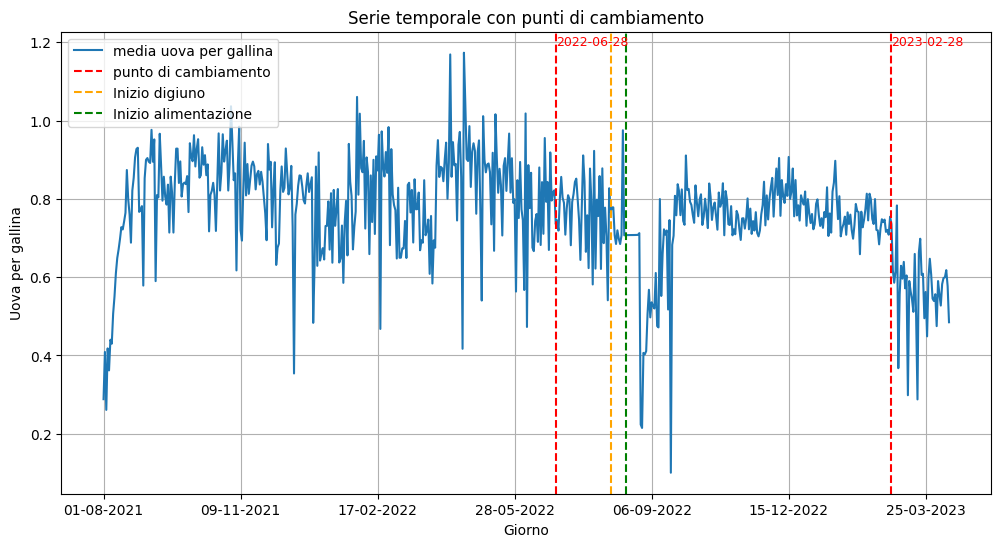

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(serie, label='media uova per gallina')

for i, cp in enumerate(change_points):
    plt.axvline(cp, color='red', linestyle='--', label='punto di cambiamento' if i==0 else "")
    plt.text(cp, max(serie)*1.01, str(change_dates[i].astype('M8[D]')), rotation=0,
             verticalalignment='bottom', color='red', fontsize=9)

# Eventi speciali
eventi = {
    'Inizio digiuno': ('2022-08-07', 'orange'),
    'Inizio alimentazione': ('2022-08-18', 'green')
}
for label, (giorno, colore) in eventi.items():
    giorno_dt = pd.to_datetime(giorno)
    # Trova l'indice più vicino nel dataframe
    idx = (df['data'] - giorno_dt).abs().idxmin()
    plt.axvline(idx, color=colore, linestyle='--', label=label)

tick_idx = range(0, len(df), 100)
plt.xticks(tick_idx, [df['data'].iloc[i].strftime('%d-%m-%Y') for i in tick_idx], rotation=0)
plt.xlabel('Giorno')
plt.ylabel('Uova per gallina')
plt.title('Serie temporale con punti di cambiamento')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [111]:
# CUSUM o Change Point Detection SETTIMANALE
# Questo ti individua punti di cambiamento strutturale nella serie temporale, 
# cioè momenti in cui la media cambia significativamente.

import ruptures as rpt

# Serie temporale
serie = df_settimanale['media_uova_per_gallina_settimanale'].values

# CUSUM test
model = rpt.Pelt(model="rbf").fit(serie)
#change_points = model.predict(pen=5)
change_points = [45, 80, 89]

print("Punti di cambiamento (indice settimana):", change_points)
# Punti di cambiamento (indice settimana): [45, 80, 89] sono giusti per me

# Converte gli indici in date corrispondenti
change_points = [cp for cp in change_points if cp < len(df_settimanale)]
change_dates = df_settimanale['data'].iloc[change_points].values
print("Punti di cambiamento (giorno):", change_dates)


Punti di cambiamento (indice settimana): [45, 80, 89]
Punti di cambiamento (giorno): ['2022-06-12T00:00:00.000000000' '2023-02-12T00:00:00.000000000']


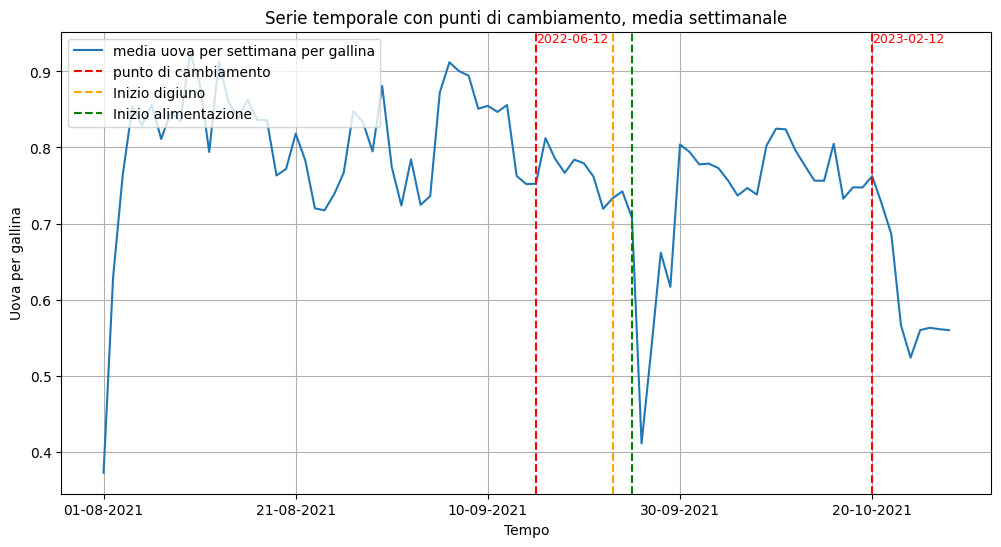

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(serie, label='media uova per settimana per gallina')

for i, cp in enumerate(change_points):
    plt.axvline(cp, color='red', linestyle='--', label='punto di cambiamento' if i==0 else "")
    plt.text(cp, max(serie)*1.01, str(change_dates[i].astype('M8[D]')), rotation=0,
             verticalalignment='bottom', color='red', fontsize=9)

# Eventi speciali
eventi = {
    'Inizio digiuno': ('2022-08-07', 'orange'),
    'Inizio alimentazione': ('2022-08-18', 'green')
}
for label, (giorno, colore) in eventi.items():
    giorno_dt = pd.to_datetime(giorno)
    # Trova l'indice più vicino nel dataframe
    idx = (df_settimanale['data'] - giorno_dt).abs().idxmin()
    plt.axvline(idx, color=colore, linestyle='--', label=label)

tick_idx = range(0, len(df_settimanale), 20)
plt.xticks(tick_idx, [df['data'].iloc[i].strftime('%d-%m-%Y') for i in tick_idx], rotation=0)
plt.xlabel('Tempo')
plt.ylabel('Uova per gallina')
plt.title('Serie temporale con punti di cambiamento, media settimanale')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# Confronto produttività primo anno vs secondo anno

In [ ]:
# confrontare “prima” e “dopo” un certo periodo (prima metà contro seconda metà) GLOBALE
# t-test per campioni indipendenti (se la distribuzione è normale)
# oppure Mann–Whitney U test (se non è normale — la distribuzione è asimmetrica con skew -2.5, quindi meglio questo)

from scipy.stats import mannwhitneyu

# Dividi la serie in due periodi
n = len(df)
first_half = df['uova_per_gallina'][:n//2]
second_half = df['uova_per_gallina'][n//2:]

stat, p = mannwhitneyu(first_half, second_half, alternative='greater')  # "greater" = prima parte più produttiva
print(f"U = {stat:.3f}, p = {p:.6f}")

U = 68906.000, p = 0.000000


C:\Users\user\AppData\Local\Temp\ipykernel_14980\2382940844.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])


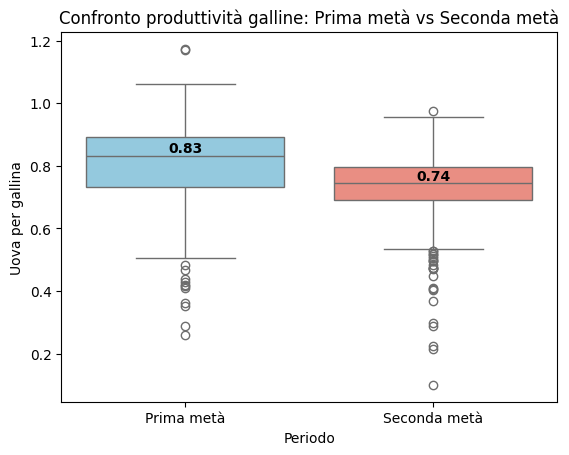

C:\Users\user\AppData\Local\Temp\ipykernel_14980\2382940844.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])


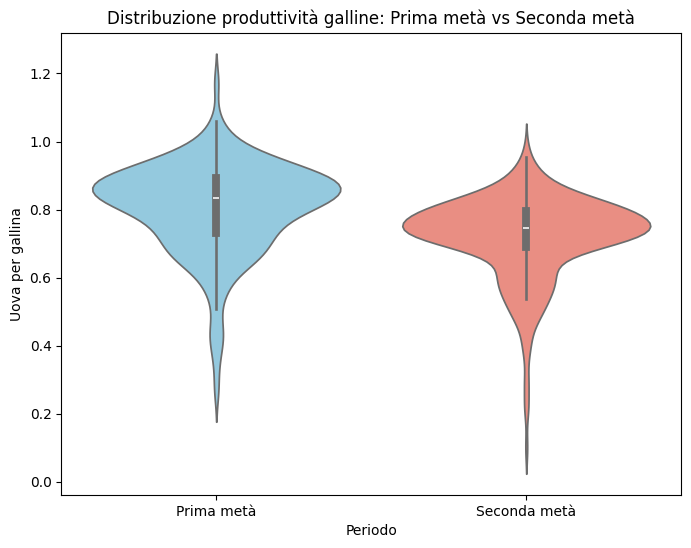

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dividi la serie in due periodi (esempio: prima e dopo metà serie)
n = len(df)
first_half = df['uova_per_gallina'][:n//2]
second_half = df['uova_per_gallina'][n//2:]

# Crea un DataFrame per il plotting
import pandas as pd
df_plot = pd.DataFrame({
    'uova_per_gallina': pd.concat([first_half, second_half], ignore_index=True),
    'Periodo': ['Prima metà']*len(first_half) + ['Seconda metà']*len(second_half)
})

# Boxplot
ax = sns.boxplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])
medians = df_plot.groupby('Periodo')['uova_per_gallina'].median()
for i, med in enumerate(medians):
    ax.text(i, med + 0.01, f'{med:.2f}', horizontalalignment='center', color='black', weight='bold')
plt.title('Confronto produttività galline: Prima metà vs Seconda metà')
plt.ylabel('Uova per gallina')
plt.show()

# Violin plot (opzionale, mostra anche distribuzione)
plt.figure(figsize=(8,6))
sns.violinplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])
plt.title('Distribuzione produttività galline: Prima metà vs Seconda metà')
plt.ylabel('Uova per gallina')
plt.show()


In [ ]:
# confrontare “prima” e “dopo” un certo periodo (prima metà contro seconda metà) SETTIMANALE
# t-test per campioni indipendenti (se la distribuzione è normale)
# oppure Mann–Whitney U test (se non è normale — la distribuzione è asimmetrica con skew -2.5, quindi meglio questo)

from scipy.stats import mannwhitneyu

# Dividi la serie in due periodi
n = len(df_settimanale)
first_half = df_settimanale['media_uova_per_gallina_settimanale'][:n//2]
second_half = df_settimanale['media_uova_per_gallina_settimanale'][n//2:]

stat, p = mannwhitneyu(first_half, second_half, alternative='greater')  # "greater" = prima parte più produttiva
print(f"U = {stat:.3f}, p = {p:.6f}")


U = 1584.000, p = 0.000001


C:\Users\user\AppData\Local\Temp\ipykernel_14980\2144160593.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])


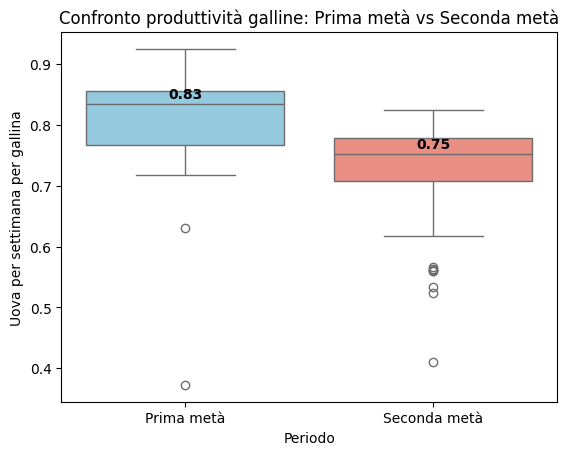

C:\Users\user\AppData\Local\Temp\ipykernel_14980\2144160593.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])


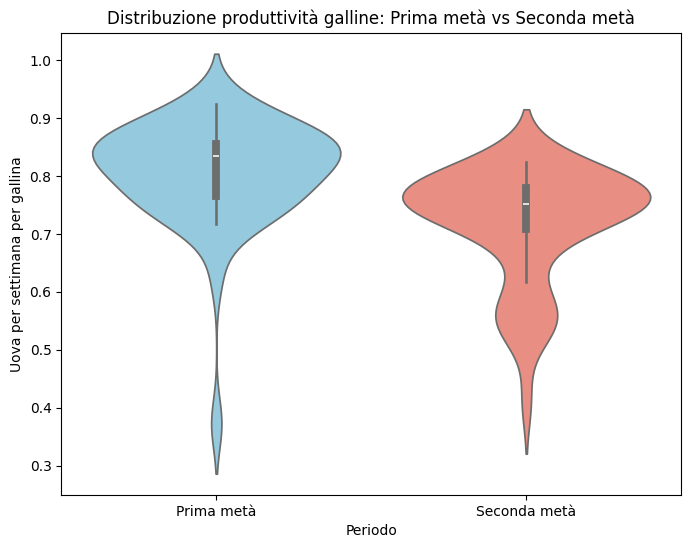

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dividi la serie in due periodi (esempio: prima e dopo metà serie)
n = len(df_settimanale)
first_half = df_settimanale['media_uova_per_gallina_settimanale'][:n//2]
second_half = df_settimanale['media_uova_per_gallina_settimanale'][n//2:]

# Crea un DataFrame per il plotting
import pandas as pd
df_plot = pd.DataFrame({
    'uova_per_gallina': pd.concat([first_half, second_half], ignore_index=True),
    'Periodo': ['Prima metà']*len(first_half) + ['Seconda metà']*len(second_half)
})

# Boxplot
ax = sns.boxplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])
medians = df_plot.groupby('Periodo')['uova_per_gallina'].median()
for i, med in enumerate(medians):
    ax.text(i, med + 0.01, f'{med:.2f}', horizontalalignment='center', color='black', weight='bold')
plt.title('Confronto produttività galline: Prima metà vs Seconda metà')
plt.ylabel('Uova per settimana per gallina')
plt.show()

# Violin plot (opzionale, mostra anche distribuzione)
plt.figure(figsize=(8,6))
sns.violinplot(x='Periodo', y='uova_per_gallina', data=df_plot, palette=['skyblue','salmon'])
plt.title('Distribuzione produttività galline: Prima metà vs Seconda metà')
plt.ylabel('Uova per settimana per gallina')
plt.show()
